# Heart Disease Classification (Group 5)


## Introduction

Heart disease is a common health condition that affects many people around the world, with coronary disease being a significant contributor to its prevalence. Coronary artery disease refers to the buildup of plaque in the wall of the arteries that supply blood to the heart, otherwise known as atherosclerosis. Plaque buildup will cause the inside of the arteries to narrow over time, leading to reduced blood flow to the heart muscle. Various diagnostic measures, such as cholesterol levels, blood pressure, and electrocardiogram (ECG) readings, play crucial roles in assessing the presence and severity of this condition. Given the significant impact of coronary disease on public health, predictive analytics can help us gain a better understanding of the relationship between risk factors and disease development, ultimately guiding efforts to prevent and manage heart disease effectively.

Through our predictive analysis, we hope to address the following question: 

**Question:** How can we use diagnostic measurements such as age, resting blood pressure, serum cholesterol, maximum heart rate, and ST depression to classify whether a patitent has heart disease? (Presence = 1,2,3,4; Absence = 0).

**Our dataset:** The dataset we have selected is a subset ofed heart disease diagnosis database that contains information about 303 unique patients undergoing angiography at the Cleveland Clinic in Cleveland, Ohio. Each entry contains 14 attributes for each patient as listed in the following: 

- Age (age)
- Sex (sex)
- Chest pain type (cp)
    - Value 1: Typical angina
    - Value 2: Atypical angina
    - Value 3: Non-anginal pain
    - Value 4: Asymptomatic   
- Resting blood pressure (trestbps)  
    - In mm Hg on admission to the hospital
- Serum cholesterol (chol)
    - In mg/dl      
- Fasting blood sugar > 120 mg/dl  (fbs)       
    - Value 0: false
    - Value 1: true
- Resting electrocardiographic results (restecg)   
    - Value 0: Normal
    - Value 1: Having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Value 2: Showing probable or definite left ventricular hypertrophy by Estes' criteria
- Maximum heart rate achieved (thalach)   
- Exercise induced angina (exang) 
    - Value 0: No
    - Value 1: Yes 
- ST depression induced by exercise relative to rest (oldpeak)   
- The slope of the peak exercise ST segment  (slope) 
    - Value 1: Upsloping
    - Value 2: Flat
    - Value 3: Downsloping  
- Number of major vessels (0-3) colored by flourosopy (ca)     
- Exercise Thallium heart scan (thal)
    - Value 3: Normal
    - Value 6: Fixed defect
    - Value 7: Reversable defect     
- Diagnosis of heart disease: Angiographic disease status (num) 
    - Value 0: < 50% diameter narrowing
    - Value 1: > 50% diameter narrowing



## Preliminary exploratory data analysis

In [1]:
library(tidyverse)
library(repr)
library(dplyr)
library(tidymodels)
library(ggplot2)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

### Reading the data

In [2]:
heart_disease_data <- read.csv("data/processed_cleveland.csv")
colnames(heart_disease_data) <- c("Age", "Sex", "Chest_Pain_Type", "Resting_Blood_Pressure", "Serum_Cholestoral", "Fasting_Blood_Sugar", "Resting_ECG", "Max_Heart_Rate", "Exercise_Induced_Angina", "ST_depression", "Slope", "Vessels_Number", "Exercise_Thallium_Heart_Scan", "Status")
heart_disease_data <- heart_disease_data |>
                mutate(Status = as_factor(Status)) |>
                mutate(Status = fct_recode(Status, "Absense" = "0", "Presence" = "1", "Presence" = "2", "Presence" = "3", "Presence" = "4"))
heart_disease_data

Age,Sex,Chest_Pain_Type,Resting_Blood_Pressure,Serum_Cholestoral,Fasting_Blood_Sugar,Resting_ECG,Max_Heart_Rate,Exercise_Induced_Angina,ST_depression,Slope,Vessels_Number,Exercise_Thallium_Heart_Scan,Status
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<chr>,<chr>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,Absense
67,1,4,160,286,0,2,108,1,1.5,2,3,3,Presence
67,1,4,120,229,0,2,129,1,2.6,2,2,7,Presence
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1,7,Presence
57,0,2,130,236,0,2,174,0,0.0,2,1,3,Presence
38,1,3,138,175,0,0,173,0,0.0,1,?,3,Absense


### Selecting potential predictors among the variables

In order to choose the right predictors for this classification problem, we selected all the numerical (non-factor) variables from the dataset.

In [3]:
# This is to separate the data/columns we will use in our model to classify whether the patient has heart disease or not.
heart_data <- select(heart_disease_data, Age, Resting_Blood_Pressure, Serum_Cholestoral, Max_Heart_Rate, ST_depression, Status)
heart_data 

Age,Resting_Blood_Pressure,Serum_Cholestoral,Max_Heart_Rate,ST_depression,Status
<int>,<int>,<int>,<int>,<dbl>,<fct>
63,145,233,150,2.3,Absense
67,160,286,108,1.5,Presence
67,120,229,129,2.6,Presence
⋮,⋮,⋮,⋮,⋮,⋮
57,130,131,115,1.2,Presence
57,130,236,174,0.0,Presence
38,138,175,173,0.0,Absense


### Summarizing the data

We are going to use only training data from this point on for our data exploration.

In [4]:
#splitting dataframe into training, testing datasets
heart_split <- initial_split(heart_data, prop = 0.75, strata = Status)

heart_train <- training(heart_split)
heart_test <- testing(heart_split)

First, we have derived some summary statistics for each of the predictor values in our dataset. The following table displays the mean of each predictor variable and the count of each observation, grouped by the patients with and without presence of heart disease in the dataset.

In [5]:
#summarizing to get mean of each predictor
heart_summary <- heart_train |>
                    group_by(Status) |>
                    summarize(mean_Age = mean(Age), mean_Resting_Blood_Pressure = mean(Resting_Blood_Pressure),
                              mean_Serum_Cholestoral = mean(Serum_Cholestoral), 
                              mean_Max_Heart_Rate = mean(Max_Heart_Rate), mean_ST_depression = mean(ST_depression),
                              n_count = n(), missing_data_count = sum(is.na(heart_train)))

heart_summary

Status,mean_Age,mean_Resting_Blood_Pressure,mean_Serum_Cholestoral,mean_Max_Heart_Rate,mean_ST_depression,n_count,missing_data_count
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
Absense,51.77236,128.8293,238.0650,158.3171,0.5471545,123,0
Presence,57.32692,134.5481,253.3269,138.6538,1.5778846,104,0


### Visualizing the data

Then, we can use the visualizations below compare the distribution of the predictors we will be using for our analysis.

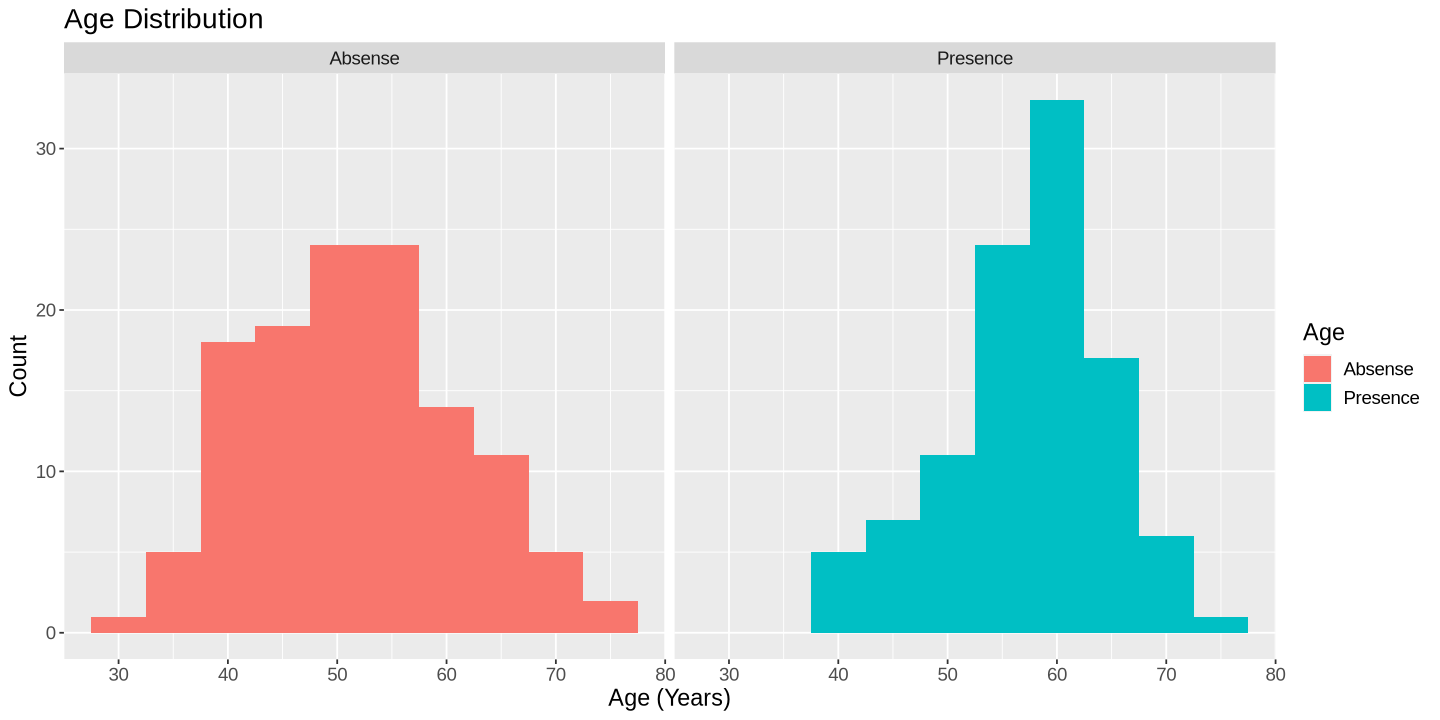

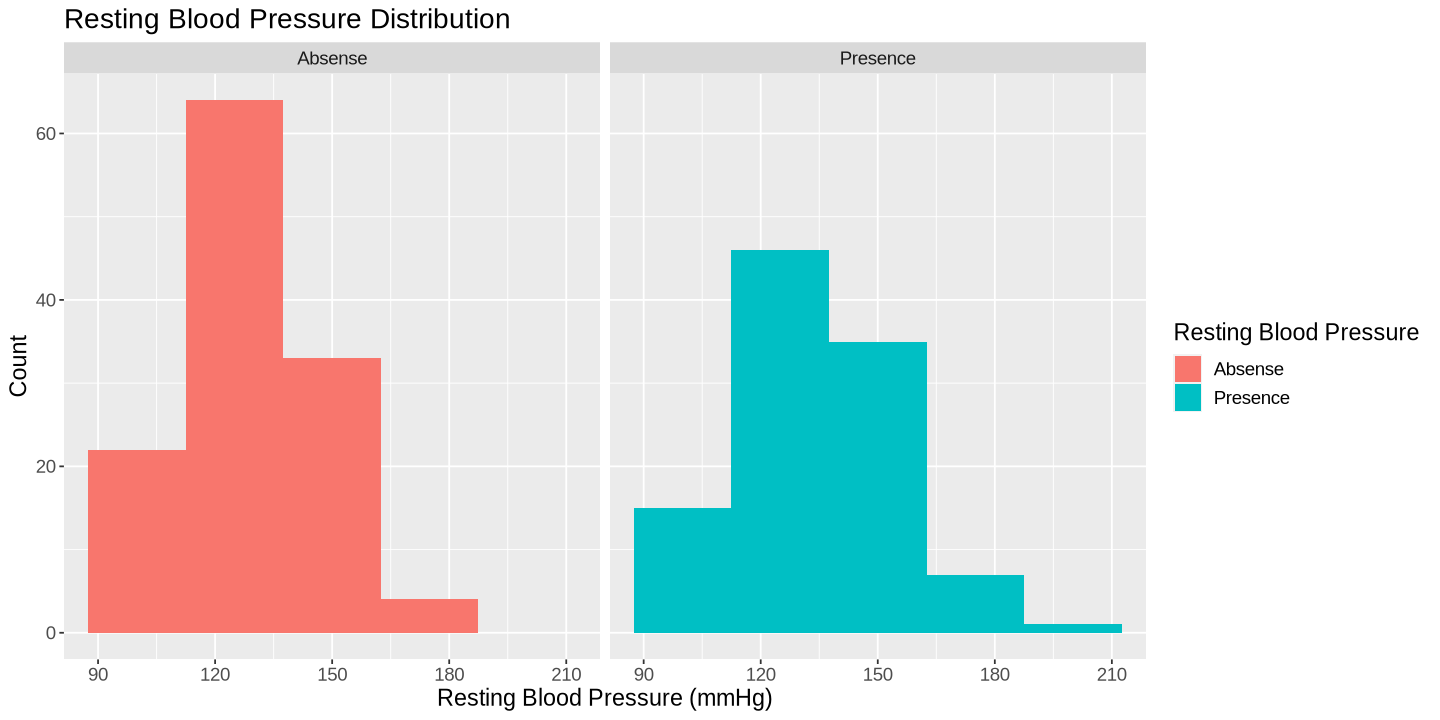

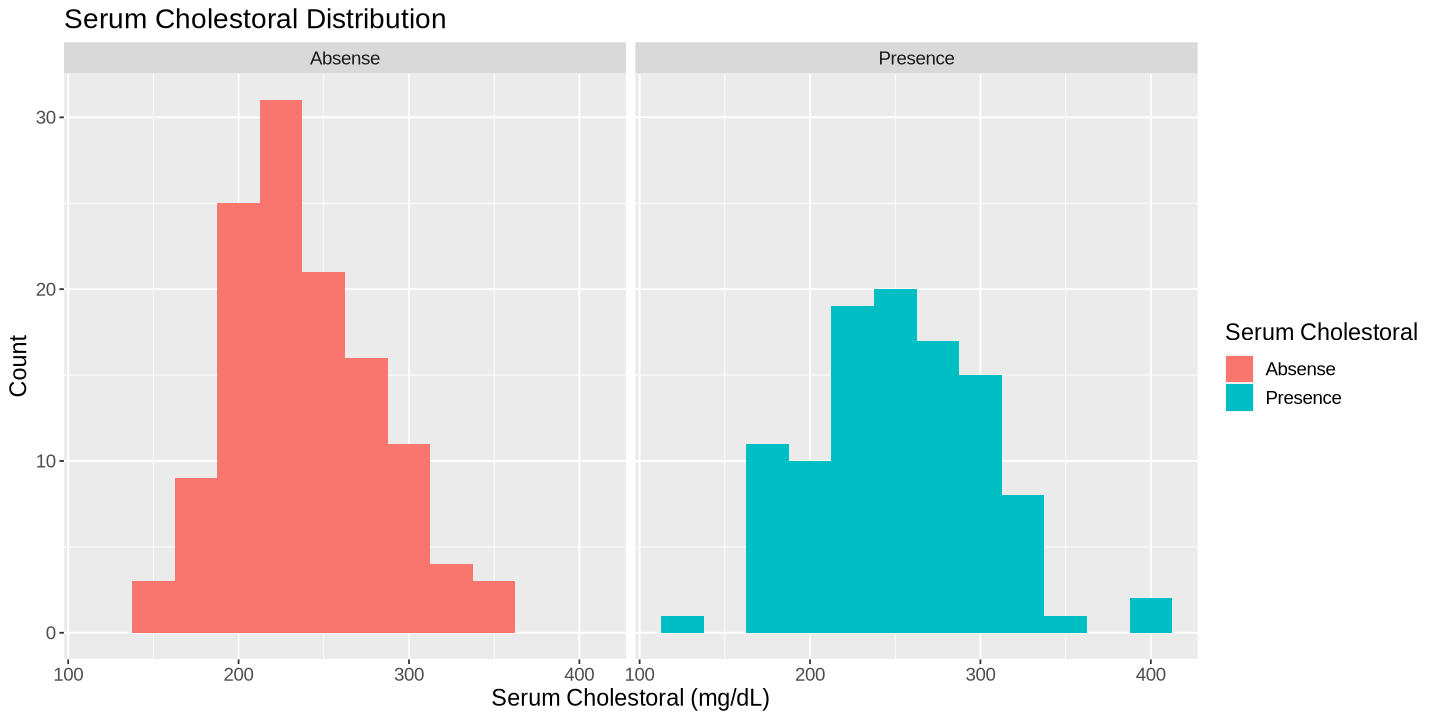

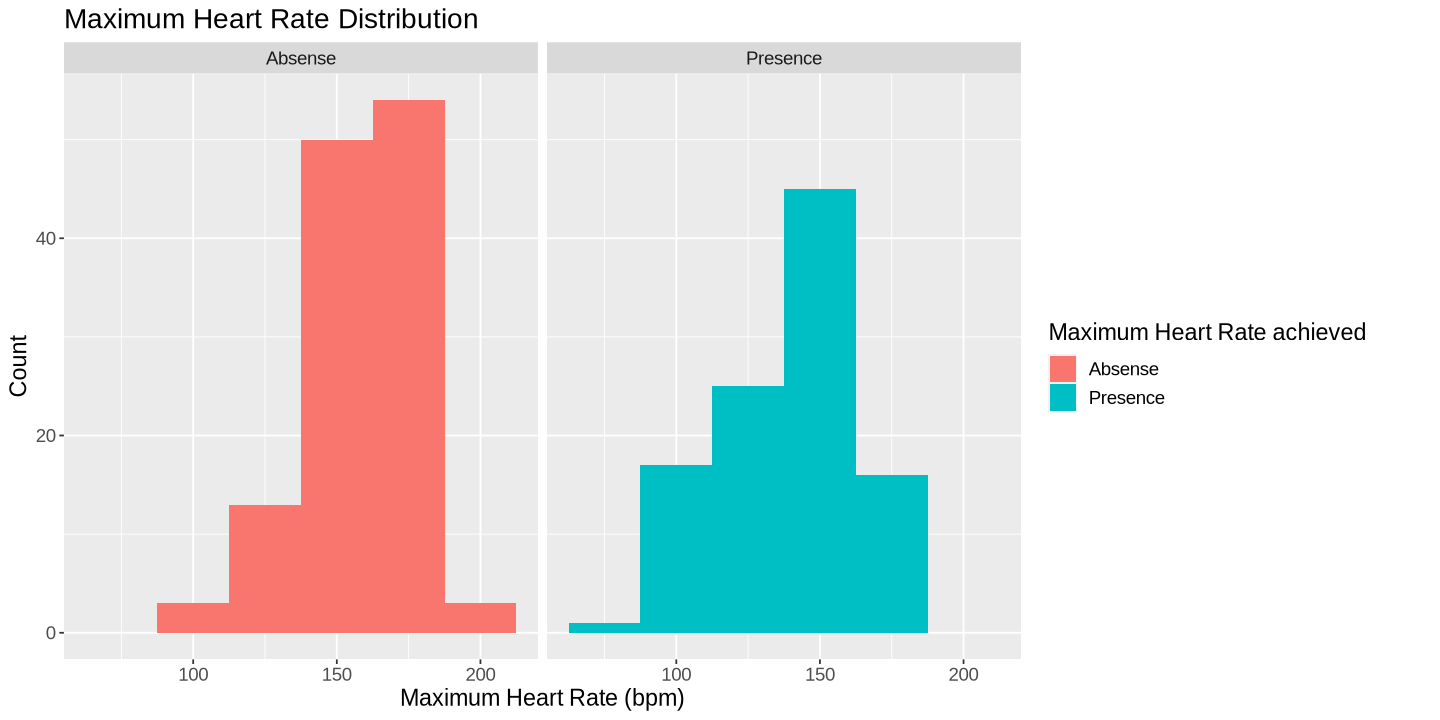

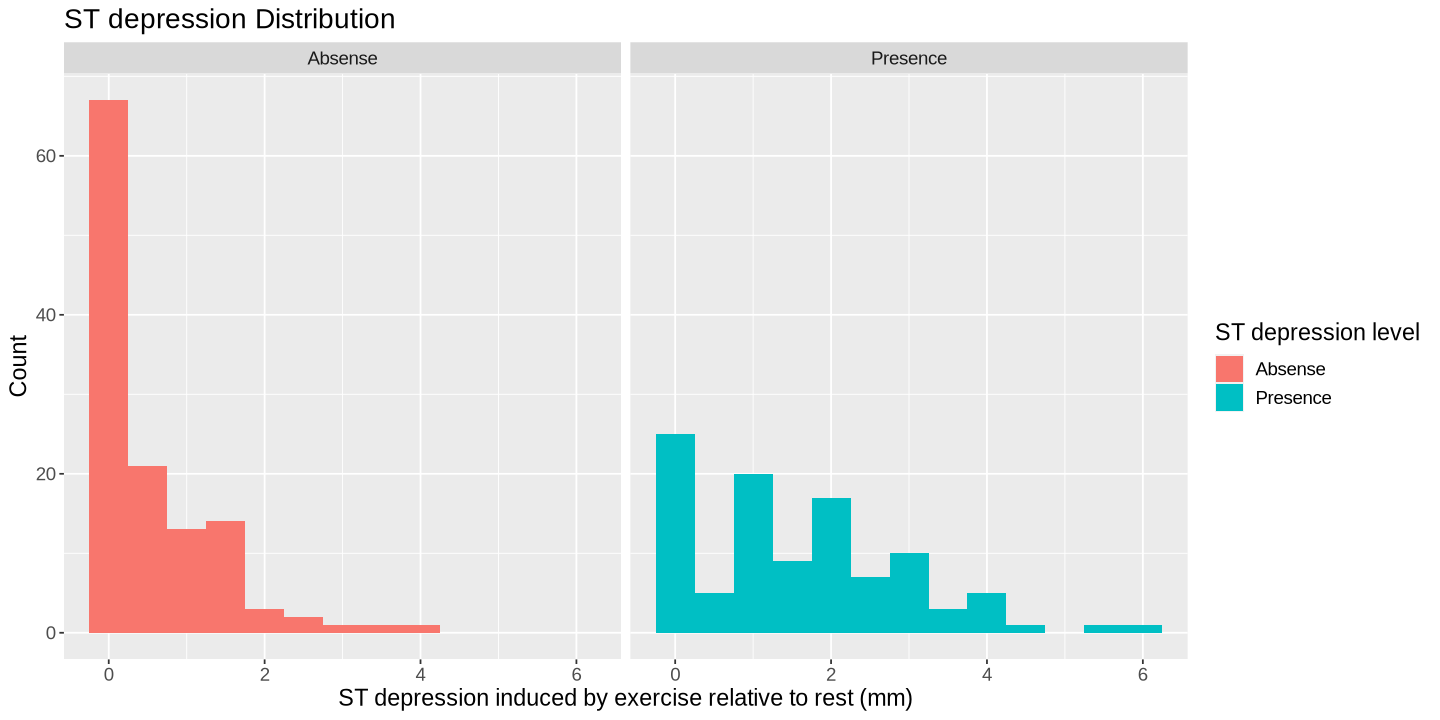

In [15]:
options(repr.plot.width=12, repr.plot.height=6)
# Age
age_distribution <- ggplot(heart_train, aes(x = Age, fill = as_factor(Status))) + 
                    geom_histogram(binwidth = 5) +
                    facet_grid(cols = vars(Status)) + 
                    labs(x = "Age (Years)", y = "Count", fill = "Age") +
                    ggtitle("Age Distribution") +
                    theme(text = element_text(size = 14))

# Resting Blood Pressure
rbp_distribution <- ggplot(heart_train, aes(x = Resting_Blood_Pressure, fill = as_factor(Status))) + 
                    geom_histogram(binwidth = 25) +
                    labs(x = "Resting Blood Pressure (mmHg)", y = "Count", fill = "Resting Blood Pressure") +
                    ggtitle("Resting Blood Pressure Distribution") +
                    facet_grid(cols = vars(Status)) + 
                    theme(text = element_text(size = 14))

# Serum Cholestoral
chol_distribution <- ggplot(heart_train, aes(x = Serum_Cholestoral, fill = as_factor(Status))) + 
                    geom_histogram(binwidth = 25) +
                    facet_grid(cols = vars(Status)) + 
                    labs(x = "Serum Cholestoral (mg/dL)", y = "Count", fill = "Serum Cholestoral") +
                    ggtitle("Serum Cholestoral Distribution") +
                    theme(text = element_text(size = 14))

# Maximum Heart Rate
maxhr_distribution <- ggplot(heart_train, aes(x = Max_Heart_Rate, fill = as_factor(Status))) + 
                    geom_histogram(binwidth = 25) +
                    facet_grid(cols = vars(Status)) + 
                    labs(x = "Maximum Heart Rate (bpm)", y = "Count", fill = "Maximum Heart Rate achieved	") +
                    ggtitle("Maximum Heart Rate Distribution") +
                    theme(text = element_text(size = 14))

# ST depression
st_distribution <- ggplot(heart_train, aes(x = ST_depression, fill = as_factor(Status))) + 
                    geom_histogram(binwidth = 0.5) +
                    facet_grid(cols = vars(Status)) + 
                    labs(x = "ST depression induced by exercise relative to rest (mm)", y = "Count", fill = "ST depression level") +
                    ggtitle("ST depression Distribution") +
                    theme(text = element_text(size = 14))
age_distribution
rbp_distribution
chol_distribution
maxhr_distribution
st_distribution

In all the plots above, we can observe that the dataset is well distributed for all the predictor variables.

Furthermore, to visualize relationships in our data, we used scatter plots to plot the predictors against each other.

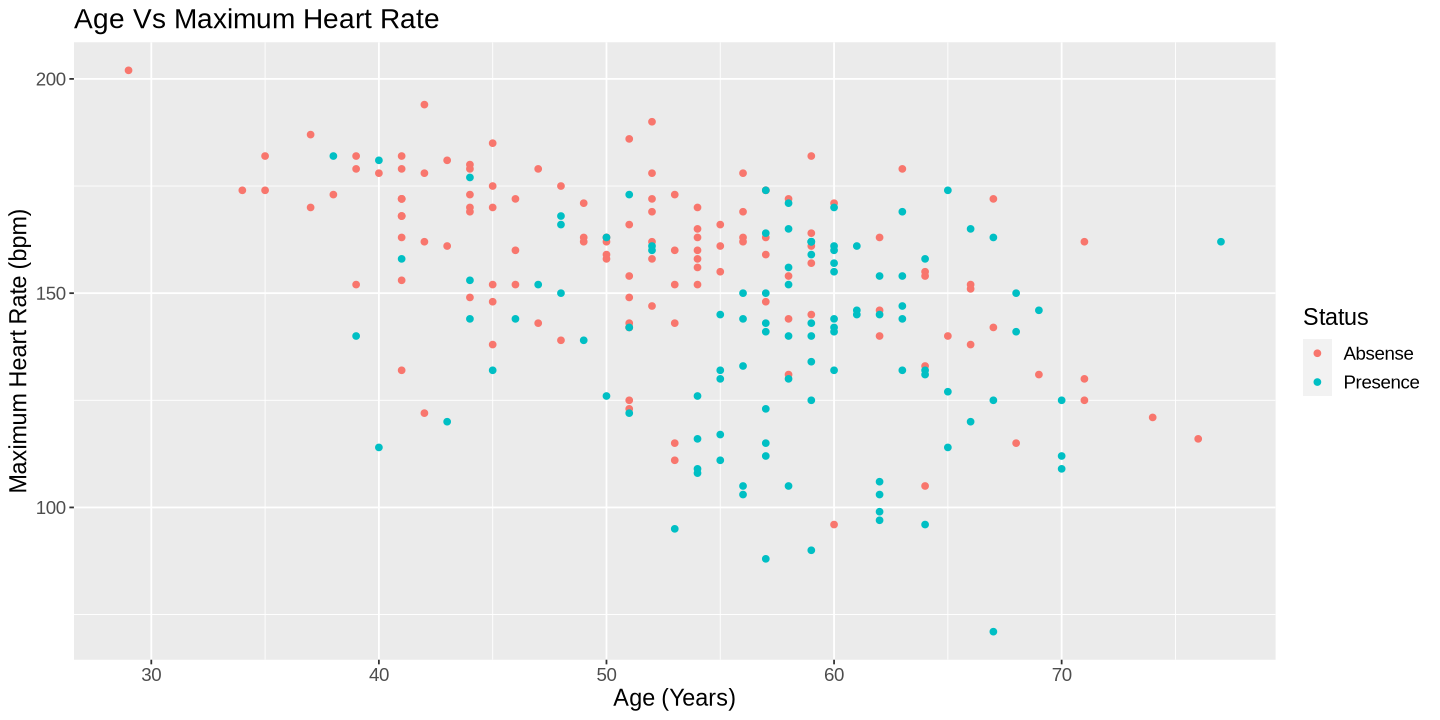

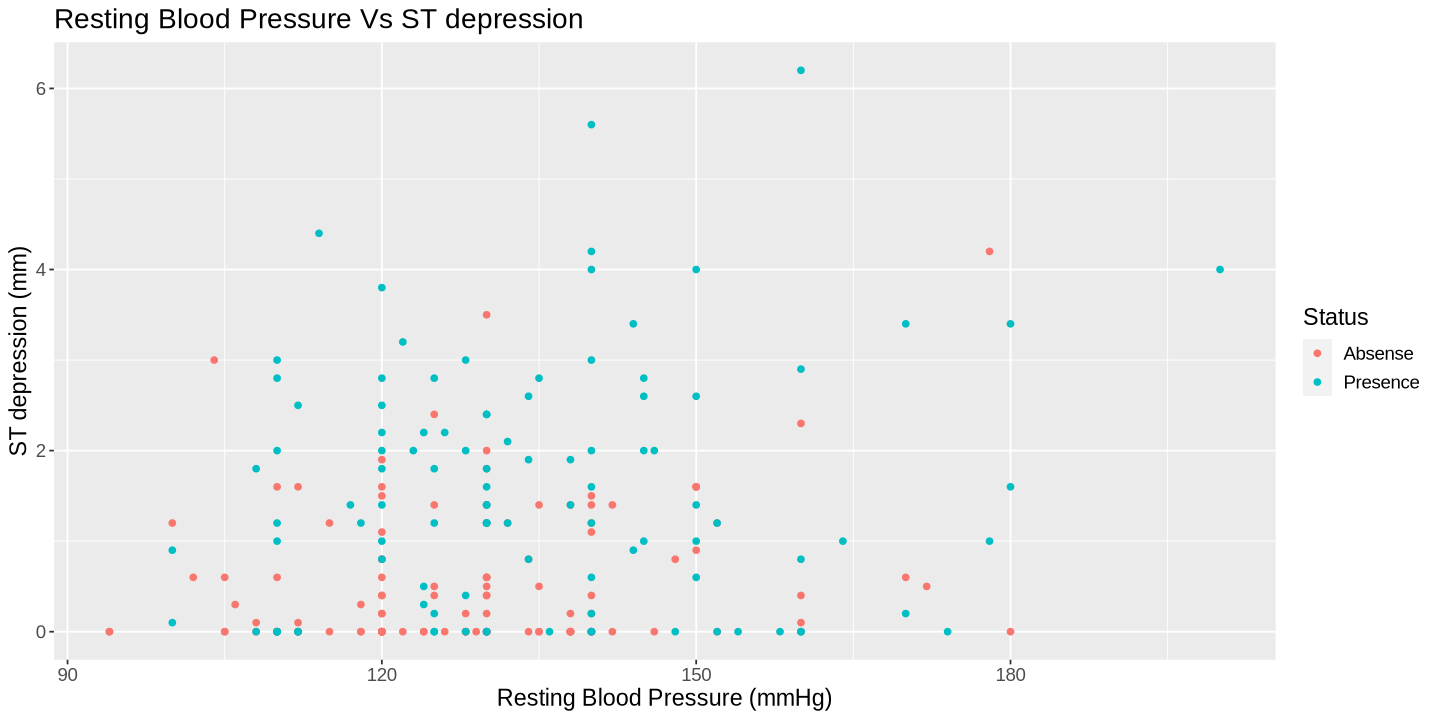

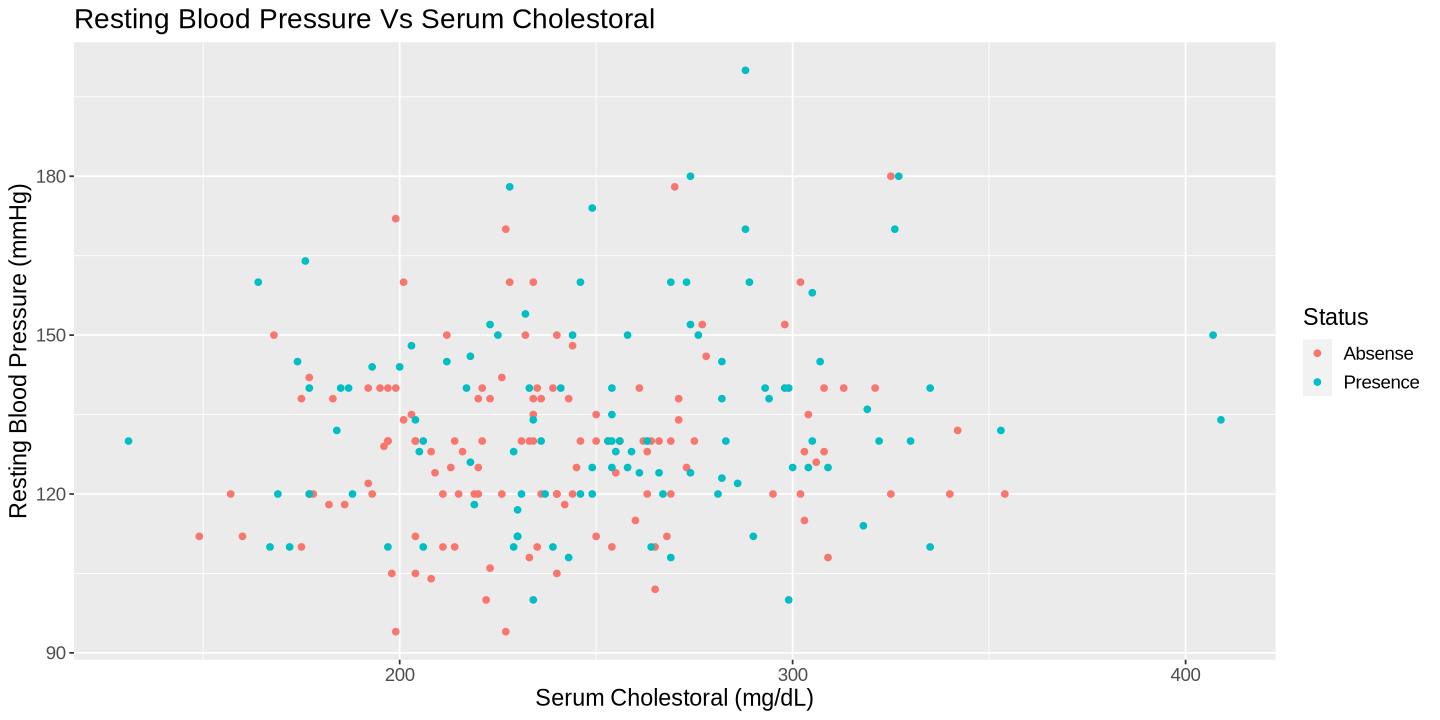

In [7]:
options(repr.plot.width=12, repr.plot.height=6)
age_vs_max_plot <- ggplot(heart_train, aes(x = Age, y = Max_Heart_Rate, color = Status)) +
                     geom_point() +
                     labs(x = "Age (Years)", y = "Maximum Heart Rate (bpm)", color = "Status") +
                     ggtitle("Age Vs Maximum Heart Rate") +
                     theme(text = element_text(size = 14))

rbp_vs_st_plot <- ggplot(heart_train, aes(x = Resting_Blood_Pressure, y = ST_depression, color = Status)) +
                     geom_point() +
                     labs(x = "Resting Blood Pressure (mmHg)", y = "ST depression (mm)", color = "Status") +
                     ggtitle("Resting Blood Pressure Vs ST depression") +
                     theme(text = element_text(size = 14))
rbp_vs_chol_plot <- ggplot(heart_train, aes(x = Serum_Cholestoral, y = Resting_Blood_Pressure, color = Status)) +
                     geom_point() +
                     labs(x = "Serum Cholestoral (mg/dL)", y = "Resting Blood Pressure (mmHg)", color = "Status") +
                     ggtitle("Resting Blood Pressure Vs Serum Cholestoral") +
                     theme(text = element_text(size = 14))

age_vs_max_plot
rbp_vs_st_plot
rbp_vs_chol_plot

From the plots above, we can see that there is a clear pattern between all the predictor variables being plotted. For example, we notice that lower maximum heart rate achieved is associated with higher age, with majority of the patients with heart disease falling in this region too, as higher age is often linked to reduced cardiovascular functions. Visualizing the data helped us identify the best predictors to use, which ended up aligning with our background research. Moreover, a region of patients with heart disease, a region of patients without, and a region of mixing of the two can be easily distinguished in all three plots above, which confirms that the predictors we selected are ideal for the classification.

## Methods

We will be using the K-nearest neighbour (knn) classification method to predict the result of our target, Status, which takes values 0 (absence) or 1,2,3,4 (presence). Among the 14 attributes provided in the original dataset, the variables we have chosen to use in our model to determine the presence of heart disease are Age, Maximum Heart Rate, Resting Blood Pressure, and Serum Cholestoral.

Our data will be standardized again before splitting into 75% training and 25% testing datasets. We will be working with the training set for our analysis and creating a model using the kknn engine. The value of K will be determined through a 5-fold cross validation.

To visualize the results we will use a scatterplot to compare the correlation between two of our predictive variables, where each point will be categorized and coloured based on whether there is a presence or absence of heart disease in a patient.
This will allow us to determine if a patient has heart disease based on these predictive factors and help visually demonstrate what conditions may increase the risk of heart disease.

## Expected outcomes and significance:

Based on our background research, we expect to find that patients with a higher age are more likely to have heart disease, as age correlates to increased risk due to deteriorating cardiovascular functions (Rodgers et al., 2019). Similarly, high blood pressure and cholesterol are major risk factors for heart disease, meaning patients classified with heart disease are more likely to have higher levels (Fryar et al., 2012). Maximum heart rate has a close inverse relationship to age (Lach et al., 2012). As heart disease risk increases with age, we may find that patients with lower heart rate, likely signifying a higher age, would lead to a higher probability of heart disease. Lastly, ST depression is a possible result seen on electrocardiograms and can often be linked to certain heart conditions. ST depression induced by exercise relative to rest, measured by the maximum depth of the depression segment (mm), can help diagnose coronary atherosclerosis and worsening cases of coronary artery disease (Lanza et al., 2002). Therefore, we may see that higher ST depression is linked to cases of heart disease.

Determining whether a patient has heart disease based on other physical factors is valuable because we can predict a patient’s risk of having heart disease without extensive medical tests. This saves time and resources. Although this does not replace actual diagnoses, this data analysis will help patients understand different risk factors associated with heart disease in order to find ways to prevent it.

The results of this project can lead to further investigation into the risk factors associated with heart disease. The Cleveland dataset contains many variables that will not be used in our predictive analysis (as seen in the introduction). Thus, this project can be expanded by taking into account other variables such as fasting blood sugar. Moreover, the Cleveland database only contains patient data from one geographical area, which may provide limitations when wanting to apply this predictive data to individuals outside of this demographic. A future project could be to compare our data set and predictive model with heart diagnosis data from other databases to determine if the correlation between certain risk factors and the presence of heart disease observed in this dataset is similar for patients in other parts of the world.

## References

Centers for Disease Control and Prevention. (2021, July 19). Coronary artery disease. Centers for Disease Control and Prevention. https://www.cdc.gov/heartdisease/coronary_ad.htm 

Fryar, C. D., Chen, T. C., & Li, X. (2012). Prevalence of uncontrolled risk factors for cardiovascular disease: United States, 1999-2010. NCHS data brief, (103), 1–8.

Janosi,Andras, Steinbrunn,William, Pfisterer,Matthias, and Detrano,Robert. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.

Lach, J., Wiecha, S., Śliż, D., Price, S., Zaborski, M., Cieśliński, I., Postuła, M., Knechtle, B., & Mamcarz, A. (2021). Hr max prediction based on age, body composition, fitness level, testing modality and sex in physically active population. Frontiers in Physiology, 12, 695950. https://doi.org/10.3389/fphys.2021.695950

Lanza, G. A., Mustilli, M., Sestito, A., Infusino, F., Sgueglia, G. A., & Crea, F. (2004). Diagnostic and prognostic value of ST segment depression limited to the recovery phase of exercise stress test. Heart (British Cardiac Society), 90(12), 1417–1421. https://doi.org/10.1136/hrt.2003.031260

Rodgers, J. L., Jones, J., Bolleddu, S. I., Vanthenapalli, S., Rodgers, L. E., Shah, K., Karia, K., & Panguluri, S. K. (2019). Cardiovascular Risks Associated with Gender and Aging. Journal of cardiovascular development and disease, 6(2), 19. https://doi.org/10.3390/jcdd6020019